
# **Hyperparameter Setting**


*   Learning Rate : 0.001
*   Normoralization : x - 전체 데이터의 mean값 / 전체 데이터의 std값
*   Batch Size : NULL
*   Epoch : 1000
*   DNN Activation Function : relu
*   Metrics : mse, mae
*   Loss Function : mse
*   Optimizer : RMSDprop
*   Dataset_Filename : 'Filtered_Dataset.npz'
*   Label_Filename : 'Ground Truth.csv'
*   Input_Size : 301
*   Hidden_Size : [100, 100, 50]







# 1. Data loading & Dataset setting



  1-1. Load dataset

In [ ]:
import numpy as np
import pathlib
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import layers
print(tf.__version__)

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.metrics import Accuracy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load dataset
# Convert array type : Numpy -> Pandas(DataFrame)
# Delete unused columns from array
dataset_column_names = [str(i) for i in range(301)]
label_column_names = ['index', 'Data_Num', 'Vth', 'Mobility', 'S-Slope', 'On/Off']
uploaded_dataset_label_path = 'Ground Truth.csv'
dataset = np.load('Filtered_Dataset.npz')['dataset']
dataset = pd.DataFrame(dataset)
label_dataset = pd.read_csv(uploaded_dataset_label_path, names = label_column_names,
                          na_values="?", comment='\t', skipinitialspace=True)
label_dataset.drop('Data_Num', axis=1, inplace=True)
label_dataset.drop('index', axis=1, inplace=True)


2.15.0


1-2. Setting input data

In [ ]:

# Make One-hot Vector label data
# Split 'Mobility' column from label_dataset(Vth, Mobility, SS, On/Off)
label_mobility = label_dataset['Mobility'].copy()
label_mobility = label_mobility.drop(0)
label_mobility = label_mobility.reset_index(drop=True)
label_mobility = label_mobility.astype(float)



# Make dataset used for model [ measured feature (idx:0~300) | mobility (idx:301)]
dataset = pd.concat([dataset, label_mobility], axis=1)
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)


1-3. Visualize input data

,count,mean,std,min,25%,50%,75%,max
0,319.0,6.834442e-10,1.194988e-08,8.200000e-12,1.210000e-11,1.350000e-11,1.520000e-11,2.134460e-07
1,319.0,5.151599e-11,6.982079e-10,6.400000e-12,1.035000e-11,1.190000e-11,1.340000e-11,1.248260e-08
2,319.0,1.387774e-11,4.415751e-11,5.800000e-12,9.300000e-12,1.090000e-11,1.230000e-11,7.967000e-10
3,319.0,1.075047e-11,4.270690e-12,4.500000e-12,8.650000e-12,1.010000e-11,1.160000e-11,4.840000e-11
4,319.0,1.024326e-11,4.151329e-12,4.400000e-12,8.100000e-12,9.700000e-12,1.120000e-11,4.780000e-11
...,...,...,...,...,...,...,...,...
296,319.0,3.519880e-03,4.006755e-04,2.275510e-03,3.224605e-03,3.524570e-03,3.830105e-03,4.640530e-03
297,319.0,3.555615e-03,4.044342e-04,2.297350e-03,3.257420e-03,3.562440e-03,3.868930e-03,4.685200e-03
298,319.0,3.591381e-03,4.083445e-04,2.319210e-03,3.290270e-03,3.599910e-03,3.908950e-03,4.729130e-03
299,319.0,3.627309e-03,4.121108e-04,2.341170e-03,3.323430e-03,3.637720e-03,3.948775e-03,4.773160e-03


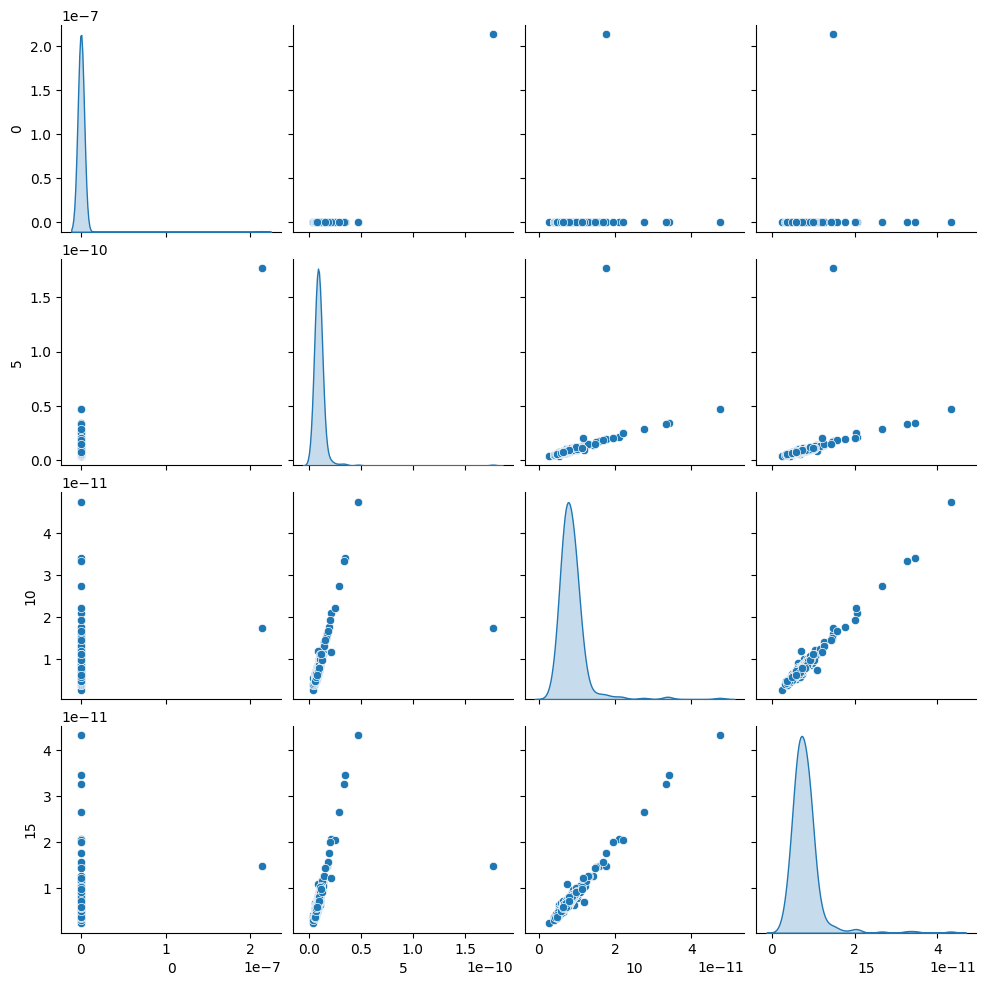

In [ ]:

# VIsualize train_dataset
sns.pairplot(train_dataset[[0, 5, 10, 15]], diag_kind="kde")

# Statistic feature of train_dataset
train_stats = train_dataset.describe()
train_stats.pop('Mobility')
train_stats = train_stats.transpose()
train_stats


1-4. Split train data, train data's label, test data, test data's label

In [ ]:

# Detach 'Mobility' column from train_dataset & test_dataset
train_labels = train_dataset.pop('Mobility')
test_labels = test_dataset.pop('Mobility')

# Data Normalization
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)




---



# 2. Construct DNN structure

In [ ]:

def build_model():
  model = keras.Sequential([
    layers.Dense(100, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(100, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 100)               30200     
                                                                 
 dense_17 (Dense)            (None, 100)               10100     
                                                                 
 dense_18 (Dense)            (None, 50)                5050      
                                                                 
 dense_19 (Dense)            (None, 1)                 51        
                                                                 
Total params: 45401 (177.35 KB)
Trainable params: 45401 (177.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________




---



# 3. train

In [ ]:

# 10 Batch size for normed_train_data
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

# While each epoch ended, print dot(.) to visualize train process
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

# 1000 Epochs
EPOCHS = 1000

# Training
history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


1/1 [==============================] - 0s 67ms/step

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
......................................

 3-1. Visualize model training process

In [ ]:

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.205103,0.345152,0.205103,77.566727,2.374514,77.566727,995
996,0.206948,0.374690,0.206948,60.797195,2.062096,60.797195,996
997,0.113785,0.267738,0.113785,80.906204,2.558177,80.906204,997
998,0.254422,0.392626,0.254422,62.186569,2.328997,62.186569,998
999,0.216484,0.369533,0.216484,75.014542,2.355244,75.014542,999


3-2. Training without EarlyStopping callback

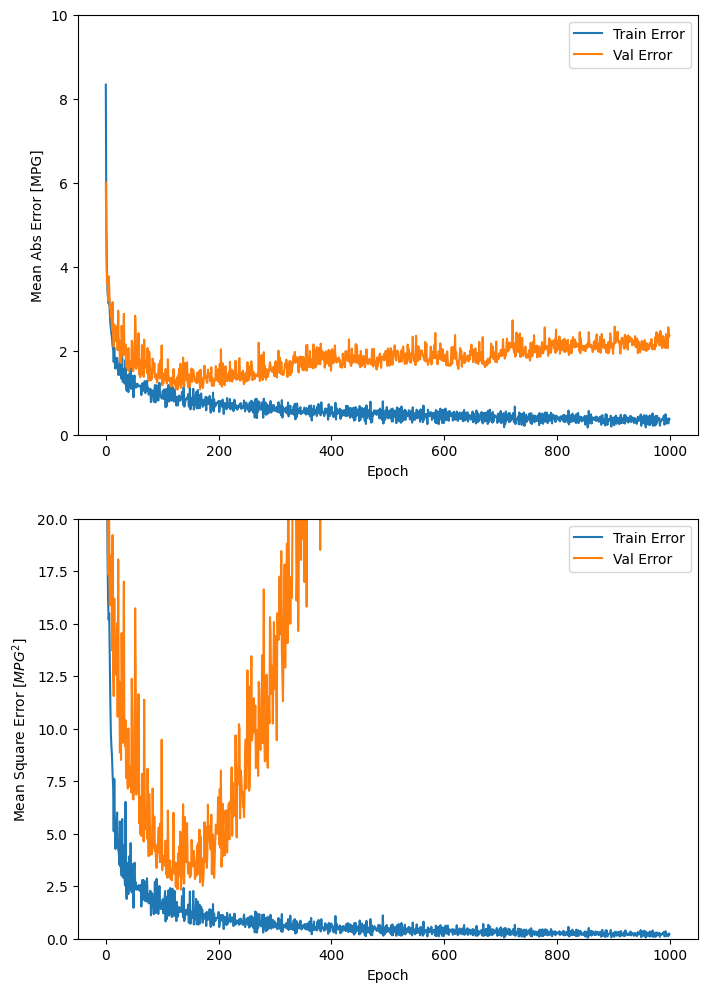

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,10])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

3-3. Train with EarlyStopping callback


...............................................................................................

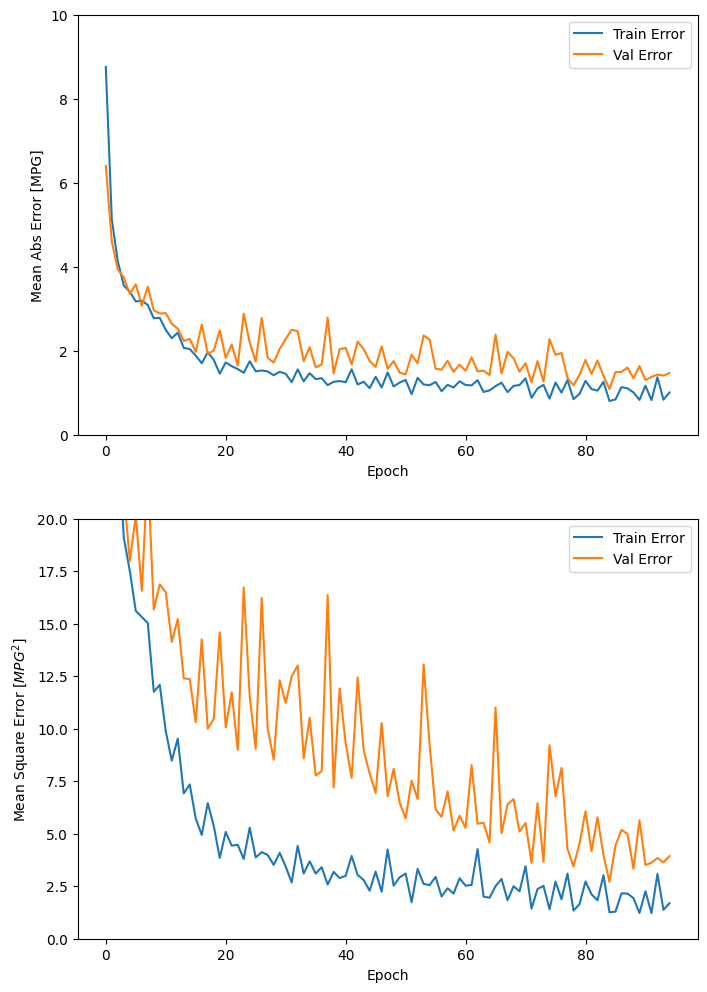

In [ ]:
model = build_model()

# patience parameter is a epoch size for checking performance improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# train
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)



---



# 5. Test

In [ ]:

# For model evaluation, change Pandas(DataFrame) to Numpy with float type
normed_test_data_array = normed_test_data.to_numpy().astype(float)

# Test
loss, mae, mse = model.evaluate(normed_test_data_array, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))


3/3 - 0s - loss: 5.2739 - mae: 1.5588 - mse: 5.2739 - 132ms/epoch - 44ms/step
테스트 세트의 평균 절대 오차:  1.56 MPG


5-1. Visualize Prediction (with test data)

3/3 [==============================] - 0s 5ms/step


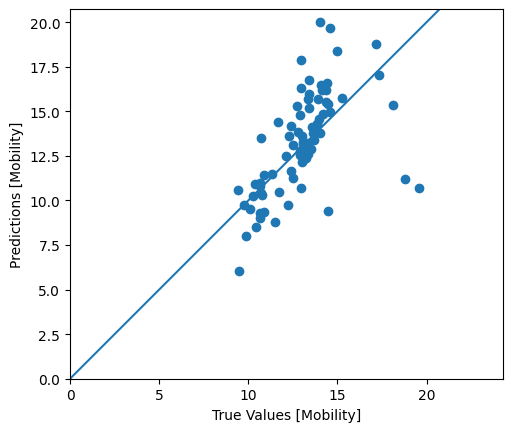

In [ ]:

test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Mobility]')
plt.ylabel('Predictions [Mobility]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


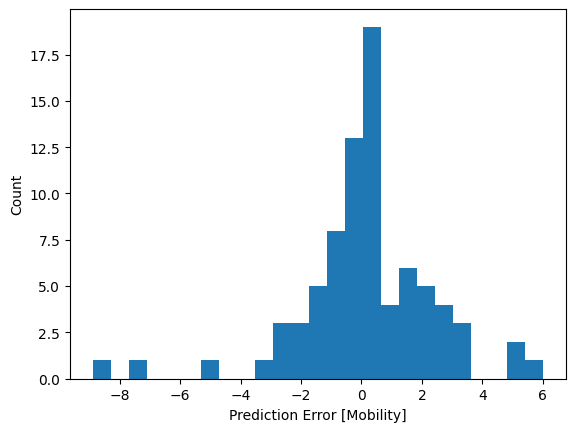

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Mobility]")
_ = plt.ylabel("Count")